In [1]:
# Imports 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from plotnine import *


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics

# Remove warning labels
import warnings
warnings.filterwarnings('ignore')

# Project 1

[This dataset](https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Proj1.csv) is adapted from the World Health Organization on Strokes (it's based on real data but is NOT REAL). Use this dataset to answer the following questions and perform the following tasks. Feel free to add extra cells as needed, but follow the structure listed here and clearly identify where each question is answered. Please remove any superflous code.

## Data Information

#### Categorical Variables 
- `reg_to_vote`: 0 if no, 1 if yes.
- `hypertension`: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension.
- `heart_disease`: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease.
- `ever_married`: 0 if no, 1 if yes.
- `Residence_type`: 0 for Rural, 1 for Urban.
- `smoking_status_smokes`, `smoking_status_formerly`: Whether or not the person smokes, or formerly smoked. If a person has 0's for both these columns, they never smoked.
- `stroke`: 1 if the patient had a stroke or 0 if not.
- `dog_owner`: 0 if no, 1 if yes.


#### Continous Variables
- `age`: age of the patient in years.
- `avg_glucose_level`: average glucose level in blood.
- `bmi`: body mass index.
- `er_visits`: number of recorded Emergency Room visits in lifetime.
- `racoons_to_fight`: number of racoons the patient belives they could fight off at once.
- `fast_food_budget_month`: amount (in US dollars) spent on fast food per month.


## Part I: Logistic Regression
Build a **logistic regression** model to predict whether or not someone had a stroke based on **all** the other variables in the dataset.

1. Count the missing data per column, and remove rows with missing data (if any).
2. Use 10 fold cross validation for your model validation. Store both the train and test accuracies to check for overfitting. **Is the model overfit? How can you tell?** Z-score your continuous variables only.
3. After completing steps 1-3, fit another logistic regression model on ALL of the data (no model validation) using the same predictors as before, and put the coefficients into a dataframe called `coef`.
4. print out a confusion matrix for the model you made in part 3. **What does this confusion matrix tell you about your model? How can you tell?**

## Part II: Data Exploration
The WHO has asked the following five questions, create **at least 1 ggplot graph** (using the above data + model when needed) to help answer each question, and **explicitly answer the question in a Markdown cell** below your graph. You may use other calculations to help support your answer but MUST pair it with a graph. Write your answer as if you were explaining it to a non-data scientist. You will be graded on the effectiveness and clarity of your graph, as well as the completeness, clarity, and correctness of your responses and justifications.

1. Do dog-ownders over 50 have a higher probability of stoke than non-dog owners who currently smoke? How can you tell?
2. What is the relationship between average blood glucose and BMI? Is the relationship between those two variables different for people who are and are not registered to vote? How can you tell?
3. Is your logistic regression model most accurate for people who make less than 30k, between 30-90k, or over 100k? Discuss the potential accuracy *and* ethical implications if your model *were* more accurate for different groups (you can use the full model from part I-3 to check accuracy).
4. Which of the following variables is the strongest predictor of having a stroke (owning a dog, residence type, marriage, being registered to vote)? How were you able to tell?
5. Create a variable `er_visits_per_year` that calculates the # of visits to the ER that a person has had per year of life. Store this variable in your data frame (no need to include this variable in the previous logistic regression model). Is the # of ER visits per year different for stroke and non-stroke patients? How can you tell?

In [2]:
# Import the data and create a dataframe
DF = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Proj1.csv")
DF

age  hypertension  heart_disease  ever_married  Residence_type  \
0      60.0           1.0            0.0           0.0             1.0   
1       4.0           0.0            0.0           0.0             0.0   
2      77.0           0.0            0.0           1.0             1.0   
3      37.0           0.0            0.0           1.0             1.0   
4      44.0           0.0            0.0           0.0             0.0   
...     ...           ...            ...           ...             ...   
14995  52.0           1.0            0.0           0.0             1.0   
14996  56.0           0.0            0.0           1.0             1.0   
14997  60.0           1.0            0.0           1.0             0.0   
14998  77.0           0.0            0.0           1.0             0.0   
14999  44.0           0.0            0.0           1.0             0.0   

       avg_glucose_level   bmi  stroke  smoking_status_smokes  \
0                  73.00  25.2       0                      1   
1                 110.15  17.1       0                      0   
2                  68.38  27.8       0                      0   
3                  95.08  30.1       0                      0   
4                 103.78  40.9       0                      1   
...                  ...   ...     ...                    ...   
14995             106.22  29.0       0                      0   
14996              63.18  26.5       0                      0   
14997             100.20  28.6       0                      0   
14998              90.00  32.0       0                      0   
14999              74.91  26.9       0                      0   

       smoking_status_formerly  reg_to_vote  dog_owner  raccoons_to_fight  \
0                            0          1.0        1.0               10.0   
1                            0          0.0        1.0               13.0   
2                            0          0.0        1.0                6.0   
3                            0          1.0        1.0               12.0   
4                            0          1.0        1.0               11.0   
...                        ...          ...        ...                ...   
14995                        0          0.0        0.0                1.0   
14996                        0          1.0        0.0               15.0   
14997                        0          0.0        1.0               17.0   
14998                        0          0.0        0.0               11.0   
14999                        0          0.0        0.0                8.0   

       fast_food_budget_month  income_in_k  er_visits  
0                      209.19    51.553645        9.0  
1                      176.46    45.405414        5.0  
2                      213.00    94.865174        8.0  
3                      161.90    84.123775        8.0  
4                      261.29    74.794596       11.0  
...                       ...          ...        ...  
14995                  179.77    74.826197        9.0  
14996                  143.61    52.280949       16.0  
14997                   64.87    92.427118       24.0  
14998                  205.92    53.042139        6.0  
14999                  184.14    70.317707        4.0  

[15000 rows x 16 columns]

## PART I

Build a logistic regression model to predict whether or not someone had a stroke based on **all** the other variables in the dataset.

1. Count the missing data per column, and remove rows with missing data (if any).

In [3]:
# counting the missing data per column
DF.isna()
DF.isna().sum()

age                         13
hypertension                12
heart_disease               21
ever_married                 9
Residence_type              21
avg_glucose_level           31
bmi                        575
stroke                       0
smoking_status_smokes        0
smoking_status_formerly      0
reg_to_vote                 14
dog_owner                   21
raccoons_to_fight           27
fast_food_budget_month       8
income_in_k                 21
er_visits                   15
dtype: int64

In [4]:
# Remove the missing data points from the Data Set
DF = DF.dropna()
DF.isna()
DF.isna().sum()

age                        0
hypertension               0
heart_disease              0
ever_married               0
Residence_type             0
avg_glucose_level          0
bmi                        0
stroke                     0
smoking_status_smokes      0
smoking_status_formerly    0
reg_to_vote                0
dog_owner                  0
raccoons_to_fight          0
fast_food_budget_month     0
income_in_k                0
er_visits                  0
dtype: int64

In [5]:
print((DF["stroke"] == 0).sum())
DF["stroke"].count()

13646


14222

2. Use 10 fold cross validation for your model validation. Store both the train and test accuracies to check for overfitting. **Is the model overfit? How can you tell?** Z-score your continuous variables only.

In [6]:
# Identify predictors 
predictors = ["age", "hypertension", "heart_disease", "ever_married", "Residence_type", "avg_glucose_level",
              "bmi", "smoking_status_smokes", "smoking_status_formerly", "reg_to_vote", "dog_owner", 
              "raccoons_to_fight", "fast_food_budget_month", "income_in_k", "er_visits"]  
# Outcome 
#["stroke"]

In [7]:
# Create predictors and outcome variables
X = DF[predictors]
y = DF["stroke"]

In [8]:
# Fix y syntax error
y = np.ravel(y)

In [9]:
# Create KFold object with 10 folds 
KF = KFold(n_splits = 10)

# Create empty Logistic Regression model
logr = LogisticRegression()

# Create empty List for accuracy score of each fold
acc_train = []
acc_test = []

In [10]:
# Use a for loop to loop through each fold and then train the model and finally record the accuracy
for train, test in KF.split(X):
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y[train]
    y_test = y[test]
    
    # fit model on training predictors and outcome variables 
    logr.fit(X_train, y_train)
    
    # Z score the continuous predictor variables
    cont_predictors = ["age", "avg_glucose_level", "bmi", "er_visits", "raccoons_to_fight", "fast_food_budget_month","income_in_k"]
    Zscore = StandardScaler()
    Zscore.fit(X_train[cont_predictors])
    X_train[cont_predictors] = Zscore.transform(X_train[cont_predictors])
    X_test[cont_predictors] = Zscore.transform(X_test[cont_predictors])

    # create predicted outcome variables
    #y_predicted = logr.predict(X_test)
    
    # append the accuracy score of each fold
    acc_train.append(accuracy_score(y_train, logr.predict(X_train)))
    
    # append the accuracy score of each fold
    acc_test.append(accuracy_score(y_test, logr.predict(X_test)))
    

In [11]:
# Create a function of the KFold cross validation with logistic regression model for later problems
def KF10_Log(DFnew, result, ravel = False):
    predictors = ["age", "hypertension", "heart_disease", "ever_married", "Residence_type", "avg_glucose_level",
              "bmi", "smoking_status_smokes", "smoking_status_formerly", "reg_to_vote", "dog_owner", "raccoons_to_fight",
              "fast_food_budget_month", "income_in_k", "er_visits"]
    
    # Set predictor and outcome variables
    Xnew = DFnew[predictors]
    ynew = DFnew["stroke"]
    
    if ravel == True:
        ynew = np.ravel(ynew)
    
    # Create KFold object with 10 folds 
    KF = KFold(n_splits = 10)

    # Create empty Logistic Regression model
    logr = LogisticRegression()

    # Create empty List for accuracy score of each fold
    acc_newtrain = []
    acc_newtest = []
    
    # Use a for loop to loop through each fold and then train the model and finally record the accuracy
    for train, test in KF.split(Xnew):
        Xnew_train = Xnew.iloc[train]
        Xnew_test = Xnew.iloc[test]
        ynew_train = ynew[train]
        ynew_test = ynew[test]

        # fit model on training predictors and outcome variables 
        logr.fit(Xnew_train, ynew_train)

        # Z score the continuous predictor variables
        cont_predictors = ["age", "avg_glucose_level", "bmi", "er_visits", "raccoons_to_fight", "fast_food_budget_month","income_in_k"]
        Zscore = StandardScaler()
        Zscore.fit(X_train[cont_predictors])
        Xnew_train[cont_predictors] = Zscore.transform(Xnew_train[cont_predictors])
        Xnew_test[cont_predictors] = Zscore.transform(Xnew_test[cont_predictors])

        # create predicted outcome variables
        #y_predicted = logr.predict(X_test)

        # append the accuracy score of each fold
        acc_newtrain.append(accuracy_score(ynew_train, logr.predict(Xnew_train)))

        # append the accuracy score of each fold
        acc_newtest.append(accuracy_score(ynew_test, logr.predict(Xnew_test)))
        
    r2_result = r2_score(ynew_train, logr.predict(Xnew_train))
        
    coef = pd.DataFrame({ "Names" : predictors, 
                     "ODDS coef" : np.exp(logr.coef_[0]), 
                     "Log-odds coef" : logr.coef_[0],
                     "Probability coef" : np.exp(logr.coef_[0]) / (1 + np.exp(logr.coef_[0]))
                     })
    
    if result == "coef":
        return coef
    
    if result == "acc_train":
        return acc_newtrain
    
    if result == "acc_test":
        return acc_newtest
    
    if result == "acc_train_mean":
        mean_acc_train = np.mean(acc_newtrain)
        return mean_acc_train
    
    if result == "acc_test_mean":
        mean_acc_test = np.mean(acc_newtest)
        return mean_acc_test
    
    if result == "r2":
        return r2_result #coef, acc,

In [12]:
# This is a function that takes a data frame and gives the accuracy score of that data frame based on the original model 
def KF10_NOFIT(DFnew, result):
    predictors = ["age", "hypertension", "heart_disease", "ever_married", "Residence_type", "avg_glucose_level",
              "bmi", "smoking_status_smokes", "smoking_status_formerly", "reg_to_vote", "dog_owner", "raccoons_to_fight",
              "fast_food_budget_month", "income_in_k", "er_visits"]
    
    # Set predictor and outcome variables
    Xnew = DFnew[predictors]
    ynew = DFnew["stroke"]
    
    # Create KFold object with 10 folds 
    KF = KFold(n_splits = 10)
    
    # Create empty List for accuracy score of each fold
    acc_newtrain = []
    acc_newtest = []
    
    # Use a for loop to loop through each fold and then train the model and finally record the accuracy
    for train, test in KF.split(Xnew):
        Xnew_train = Xnew.iloc[train]
        Xnew_test = Xnew.iloc[test]
        ynew_train = ynew[train]
        ynew_test = ynew[test]
        
        # Use the original Logistic Regression Model made from the original DF
        
        # append the accuracy score of each fold
        acc_newtrain.append(accuracy_score(ynew_train, logr.predict(Xnew_train)))

        # append the accuracy score of each fold
        acc_newtest.append(accuracy_score(ynew_test, logr.predict(Xnew_test)))
        
    if result == "acc_train":
        return acc_newtrain
    
    if result == "acc_test":
        return acc_newtest
    
    if result == "acc_train_mean":
        mean_acc_train = np.mean(acc_newtrain)
        return mean_acc_train
    
    if result == "acc_test_mean":
        mean_acc_test = np.mean(acc_newtest)
        return mean_acc_test

In [13]:
# Accuracy Score of the training set
print(acc_train)
np.mean(acc_train)

[0.9592155637159153, 0.9607000546917728, 0.95984375, 0.958671875, 0.959296875, 0.95921875, 0.95984375, 0.960234375, 0.958671875, 0.958984375]


0.9594681243407688

In [14]:
# Accuracy Score of the testing set
print(acc_test)
np.mean(acc_test)

[0.9613492621222769, 0.9486999297259311, 0.9556962025316456, 0.9669479606188467, 0.960618846694796, 0.9620253164556962, 0.9563994374120957, 0.9528832630098453, 0.9662447257383966, 0.9641350210970464]


0.9594999965406578

#### Comment on Overfitting

Since the Accuracy Score of the model using the training data is negagibly below the Accuracy Score of the model using the testing set data I am not concerned about overfitting for this model. Had the difference in the Accuracy Score for the training set vs the Accuracy Score of the testing set been larger (about 100x what it is now) then I would be concerned about overfitting for this model. 

3. After completing steps 1-3, fit another logistic regression model on ALL of the data (no model validation) using the same predictors as before, and put the coefficients into a dataframe called `coef`.

In [15]:
# Z Score continuous Variables 
cont_predictors = ["age", "avg_glucose_level", "bmi", "er_visits", "raccoons_to_fight", "fast_food_budget_month","income_in_k"]
Zscore = StandardScaler()
Zscore.fit(X[cont_predictors])
X[cont_predictors] = Zscore.transform(X[cont_predictors])

In [16]:
# Make a new logistic Regression Model without Cross Validation
logrnew = LogisticRegression()
logrnew.fit(X, y)

LogisticRegression()

In [17]:
# Create a new data frame of the coefficients of the linear model
coef = pd.DataFrame({ "Names" : predictors, 
                     "ODDS coef" : np.exp(logrnew.coef_[0]), 
                     "Log-odds coef" : logrnew.coef_[0],
                     "Probability coef" : np.exp(logrnew.coef_[0]) / (1 + np.exp(logrnew.coef_[0]))
                     })

#coef = coef.append({ "Coef" : logrnew.intercept_, "Names" : "intercept"}, ignore_index = True)

coef

Names  ODDS coef  Log-odds coef  Probability coef
0                       age   5.018449       1.613121          0.833844
1              hypertension   1.283438       0.249543          0.562064
2             heart_disease   1.527140       0.423396          0.604296
3              ever_married   0.828644      -0.187965          0.453147
4            Residence_type   0.980405      -0.019790          0.495053
5         avg_glucose_level   1.274811       0.242798          0.560403
6                       bmi   1.118171       0.111694          0.527894
7     smoking_status_smokes   1.342612       0.294617          0.573126
8   smoking_status_formerly   1.156817       0.145672          0.536354
9               reg_to_vote   0.941835      -0.059925          0.485023
10                dog_owner   1.015539       0.015419          0.503855
11        raccoons_to_fight   0.989708      -0.010345          0.497414
12   fast_food_budget_month   2.031054       0.708555          0.670082
13              income_in_k   1.134348       0.126058          0.531473
14                er_visits   1.058398       0.056757          0.514185

4. print out a confusion matrix for the model you made in part 3. **What does this confusion matrix tell you about your model? How can you tell?**

In [18]:
# Create predicted outcomes from the Logistical Regression
y_predicted = logrnew.predict(X)

In [19]:
# print the confusion matrix of the logistical regression model
confusion_matrix(y, y_predicted)

array([[13635,    11],
       [  552,    24]], dtype=int64)

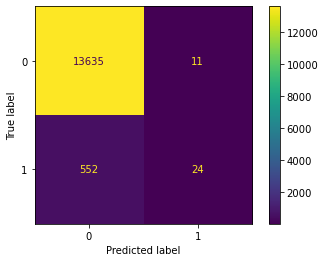

In [20]:
plot_confusion_matrix(logrnew, X, y)

#### Comment of Confusion Matrix

The Confusion Matrix tells me that our logistic regression model is fairly accurate overall. 

In the upperleft corner we have the times where our model predicted that a person did **not** have a stroke an the actual data confirmed that the patient did **not** have a stroke. As we can see the number is fairly large when compaired to the other three corners. Additionally, the amount of times our model predicted that a patient did have a stroke and the data showed that the patient did **not** have a stroke (the upper right corner) is extremely low, so our model had relatively few false positives. This is good in general, however if we look at the lower left and right corners we see some concerning results. 

The lower left corner is where our model predicted that the patient would not have a stroke and the patient **did** have a stroke according to the data. The fact that this is a number above zero is concerning but no model is perfect, however, it is fairly large compared two the left column of the confusion matrix. The size of this number is concerning because it means our model predicted that a patient would not have a stroke and the data shows that the pacient did have a stroke. The bigger this number is in the lower left the more inaccurate our model is, therefore we would like to see a smaller number relative to the other corners. 

The lower right corner is where our model predicted the patient would have a stroke and the patient did had a stroke according to the data. Although the number in this corner is above zero it is still extremely small especially compared to the false negative in the lower left corner. Ideally we would like to see the size of these two numbers in the lower half of the matrix reversed, meaning our model was more accurate at predicting a patient would have a stroke verses being inaccurate about when a patient had a stroke.

Overall the model with no cross validation is doing fairly well but there are certianly areas for improvement. 

## PART II

## Part II: Data Exploration
The WHO has asked the following five questions, create **at least 1 ggplot graph** (using the above data + model when needed) to help answer each question, and **explicitly answer the question in a Markdown cell** below your graph. You may use other calculations to help support your answer but MUST pair it with a graph. Write your answer as if you were explaining it to a non-data scientist. You will be graded on the effectiveness and clarity of your graph, as well as the completeness, clarity, and correctness of your responses and justifications.

1. Do dog-ownders over 50 have a higher probability of stoke than non-dog owners who currently smoke? How can you tell?

In [21]:
# Create a new data frame with a column of dog-owners over 50
dog = (DF["dog_owner"] == True) & (DF["age"] > 50)
DFdog = DF.copy()
DFdog["Dog_owner_over_50"] = dog
# DFdog

In [22]:
# Identify the probability that a dog owner over 50 will have a stroke
prob_dog_over50 = ((DF[dog]["stroke"]).sum()) / ((DF["stroke"]).sum()) # number of dog owners over 50 who had a stroke / Total number of people who had a stroke
prob_dog_over50

0.53125

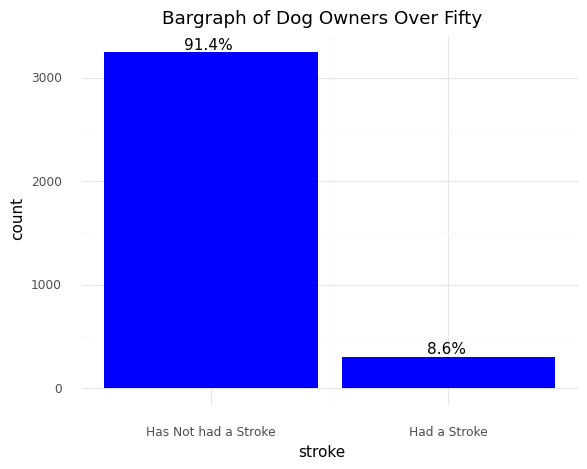

<ggplot: (178291552997)>

In [23]:
(ggplot(DFdog[dog], aes(x = "stroke")) + geom_bar(fill = "blue") 
 + scale_x_continuous(breaks = [0,1], labels = ["Has Not had a Stroke", "Had a Stroke"])
#  + facet_wrap("~Dog_owner_over_50")
 + theme_minimal()
 + ggtitle("Bargraph of Dog Owners Over Fifty")
 + geom_text(
     aes(label=after_stat('prop*100')),
     stat='count',
     nudge_y=0.125,
     va='bottom',
     format_string='{:.1f}% '
 )
)


In [24]:
# Create a new data frame with a column of dog-owners over 50
smokes = (DF["dog_owner"] == False) & (DF["smoking_status_smokes"] == True)
DFsmokes = DF.copy()
DFsmokes["smokes_noDog"] = smokes
# DFsmokes

In [25]:
prob_smoker_nodog = ((DFsmokes[smokes]["stroke"] == 1).sum()) / ((DF["stroke"] == 1).sum())
prob_smoker_nodog 

0.05555555555555555

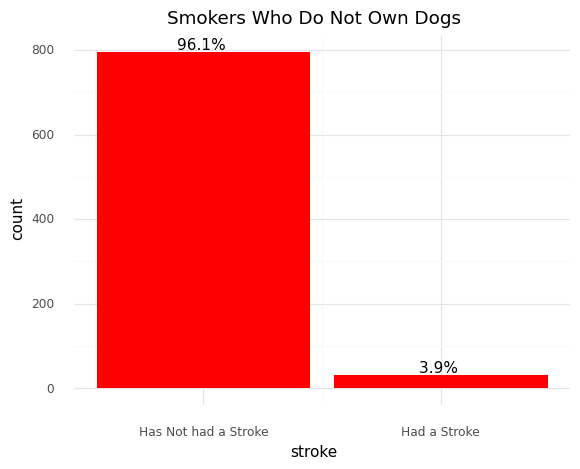

<ggplot: (178291536116)>

In [26]:
(ggplot(DFsmokes[smokes], aes(x = "stroke")) + geom_bar(fill = "red") 
 + scale_x_continuous(breaks = [0,1], labels = ["Has Not had a Stroke", "Had a Stroke"])
 #+ facet_wrap("~smokes_noDog")
 + theme_minimal()
 + ggtitle("Smokers Who Do Not Own Dogs")
 #+ stat_summary(geom = "bar") 
 + geom_text(
     aes(label=after_stat('prop*100')),
     stat='count',
     nudge_y=0.125,
     va='bottom',
     format_string='{:.1f}% '
 )
)

#### Do dog-ownders over 50 have a higher probability of stoke than non-dog owners who currently smoke? How can you tell?

From the above graphs of *Dog Owners Over 50 vs. Stroke* and *Smokers Who Do Not Own Dogs vs. Stroke* we can see that the amount of both dog owners over 50 and smokers who do not own dogs that **did not** a have a stroke is fairly large compared to the amount of dog owners over 50 and smokers who do not own dogs who **did** had a stroke. However, calculating the percentages of having a stroke between the two types of people (dog owners over 50 and smokers who do not own dogs) we see that dog owners over 50 have a higher percentage of having a stroke than smokers who do not own a dog with a 53.125 percent chance of having a stroke for dog owners over 50 versus a 5.555 percent chance of having a stroke for smokers who do not own dogs. 

2. What is the relationship between average blood glucose and BMI? Is the relationship between those two variables different for people who are and are not registered to vote? How can you tell?


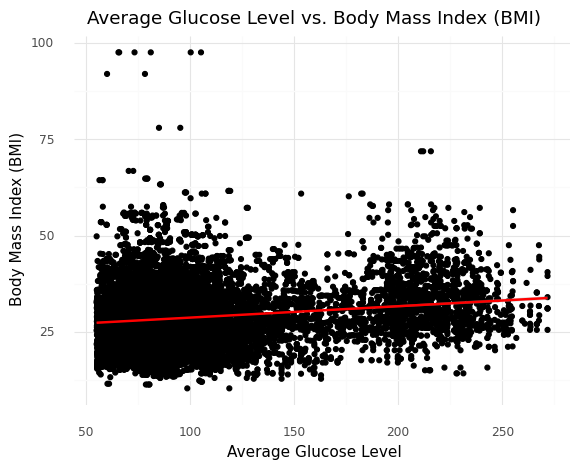

<ggplot: (178291798086)>

In [27]:
# Create a plot of the average glucose level vs the body mass index
(ggplot(DF, aes(x = "avg_glucose_level", y = "bmi")) + geom_point()
 + theme_minimal()
 + stat_smooth(color = "red")
 + ggtitle("Average Glucose Level vs. Body Mass Index (BMI)")
 + labs(x = "Average Glucose Level", y = "Body Mass Index (BMI)")
)

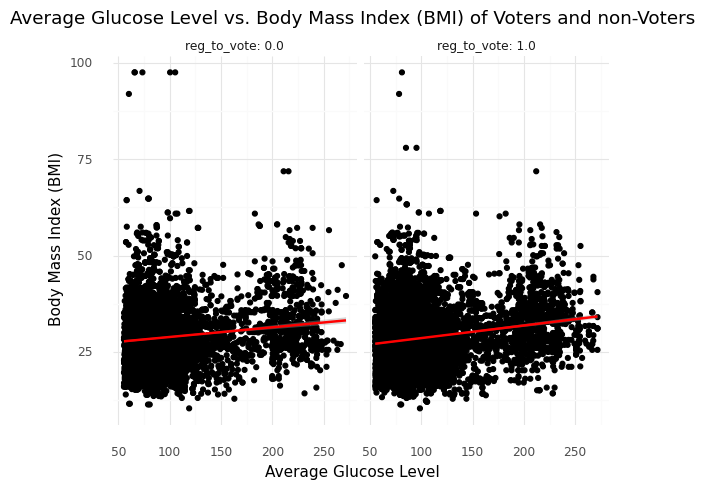

<ggplot: (178292243643)>

In [28]:
# Create a plot of the average glucose level vs the body mass index but split the results by registered to vote 
(ggplot(DF, aes(x = "avg_glucose_level", y = "bmi")) + geom_point()
 + theme_minimal()
 + stat_smooth(color = "red")
 + facet_wrap("~reg_to_vote", labeller = "label_both")
 + ggtitle("Average Glucose Level vs. Body Mass Index (BMI) of Voters and non-Voters")
 + labs(x = "Average Glucose Level", y = "Body Mass Index (BMI)")
)

#### Relationship between Average Glucose Level and Body Mass Index

From the *Average Glucose Level vs. Body Mass Index (BMI)* plot above we can see that there appears a *roughly* linear relationship between the average glucose level and bmi. The red line indicates the caculated smoothed conditional mean of the data set, since the mean of the dataset appears to be roughly increasing linearly the red line takes the form of a straight line that is increasing over the average glucose level. From the *Average Glucose Level vs. Body Mass Index (BMI) of Voters and non-Voters* plot above we see that the trend identified in the *Average Glucose Level vs. Body Mass Index (BMI)* continues for both registered voters and  non-registered voters.

3. Is your logistic regression model most accurate for people who make less than 30k, between 30-90k, or over 100k? Discuss the potential accuracy *and* ethical implications if your model *were* more accurate for different groups (you can use the full model from part I-3 to check accuracy).

## Income less than 30,000

In [29]:
# Less than 30k Logistic Regression model
income_less30 = DF["income_in_k"] < 30.0
DFless30 = DF[income_less30].copy()
DFless30.reset_index(inplace= True)
DFless30 = DFless30.drop(columns = ["index"])

In [30]:
KF10_NOFIT(DFless30, "acc_test_mean")

0.9958333333333333

In [31]:
# Set predictor and outcome variables
Xless30 = DFless30[predictors]
yless30 = DFless30["stroke"]

# Create KFold object with 10 folds 
KF = KFold(n_splits = 10)

acc_less30train = []
acc_less30test = []


# Use a for loop to loop through each fold and then train the model and finally record the accuracy
for train, test in KF.split(Xless30):
    Xless30_train = Xless30.iloc[train]
    Xless30_test = Xless30.iloc[test]
    yless30_train = yless30[train]
    yless30_test = yless30[test]
    
    # append the accuracy score of each fold
    acc_less30train.append(accuracy_score(yless30_train, logr.predict(Xless30_train)))

        # append the accuracy score of each fold
    acc_less30test.append(accuracy_score(yless30_test, logr.predict(Xless30_test)))

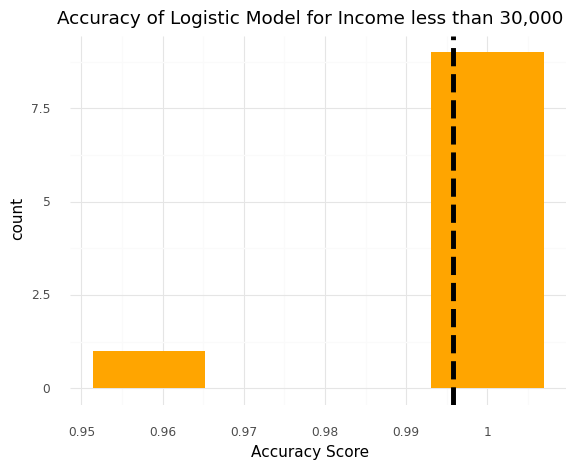

<ggplot: (178291773450)>

In [64]:
acc30 = pd.DataFrame({"acc" : acc_less30test})
(ggplot(acc30, aes(x = "acc")) + geom_histogram(fill = "orange") + theme_minimal()
 + labs(x = "Accuracy Score")
 + ggtitle("Accuracy of Logistic Model for Income less than 30,000")
 + geom_vline(xintercept = np.mean(acc_less30test), linetype = "dashed", size = 2)
)

## Income between 30,000 and 90,000

In [33]:
# Between 30k and 90k Logistic Regression model
income_30through90 = (DF["income_in_k"] > 30.0) & (DF["income_in_k"] < 90.0)
DF30n90 = DF[income_30through90].copy()
DF30n90.reset_index(inplace= True)
DF30n90 = DF30n90.drop(columns = ["index"])
# DF30n90
# print(KF10_Log(DF30n90, "r2"))
# KF10_Log(DF30n90, "acc_test_mean")

In [34]:
KF10_NOFIT(DF30n90, "acc_test_mean")

0.9600572709770185

In [35]:
# Set predictor and outcome variables
X30n90 = DF30n90[predictors]
y30n90 = DF30n90["stroke"]

# Create KFold object with 10 folds 
KF = KFold(n_splits = 10)

acc_30n90train = []
acc_30n90test = []

# Use a for loop to loop through each fold and then train the model and finally record the accuracy
for train, test in KF.split(X30n90):
    X30n90_train = X30n90.iloc[train]
    X30n90_test = X30n90.iloc[test]
    y30n90_train = y30n90[train]
    y30n90_test = y30n90[test]
    
     # append the accuracy score of each fold
    acc_30n90train.append(accuracy_score(y30n90_train, logr.predict(X30n90_train)))

        # append the accuracy score of each fold
    acc_30n90test.append(accuracy_score(y30n90_test, logr.predict(X30n90_test)))

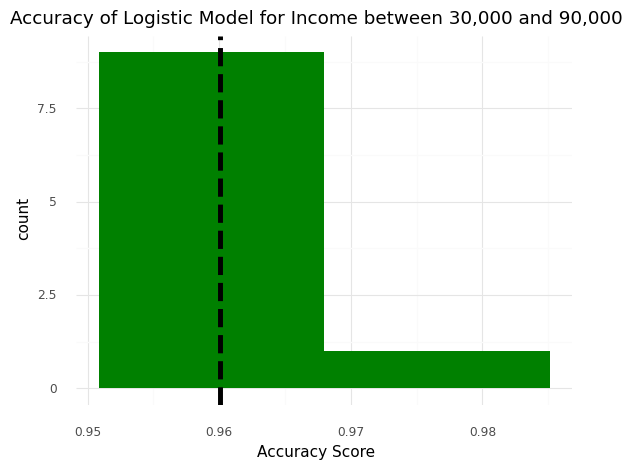

<ggplot: (178292234493)>

In [65]:
acc30n90 = pd.DataFrame({"acc1" : acc_30n90test})

(ggplot(acc30n90, aes(x = "acc1")) + geom_histogram(fill = "green") + theme_minimal()
 + labs(x = "Accuracy Score")
 + ggtitle("Accuracy of Logistic Model for Income between 30,000 and 90,000")
 + geom_vline(xintercept = np.mean(acc_30n90test), linetype = "dashed", size = 2)
)

## Income over 100,000

In [37]:
# Over 100K Logistic Regression model
income_greater100 = DF["income_in_k"] > 100.0
DF100 = DF[income_greater100].copy()
DF100.reset_index(inplace= True)
DF100 = DF100.drop(columns = ["index"])
# DF100
# print(KF10_Log(DF100, "r2"))
# KF10_Log(DF100, "acc_test_mean")

In [38]:
KF10_NOFIT(DF100, "acc_test_mean")

0.9480532854959802

In [39]:
# Set predictor and outcome variables
X100 = DF100[predictors]
y100 = DF100["stroke"]

# Create KFold object with 10 folds 
KF = KFold(n_splits = 10)

acc_100train = []
acc_100test = []

# Use a for loop to loop through each fold and then train the model and finally record the accuracy
for train, test in KF.split(X100):
    X100_train = X100.iloc[train]
    X100_test = X100.iloc[test]
    y100_train = y100[train]
    y100_test = y100[test]
    
     # append the accuracy score of each fold
    acc_100train.append(accuracy_score(y100_train, logr.predict(X100_train)))

        # append the accuracy score of each fold
    acc_100test.append(accuracy_score(y100_test, logr.predict(X100_test)))

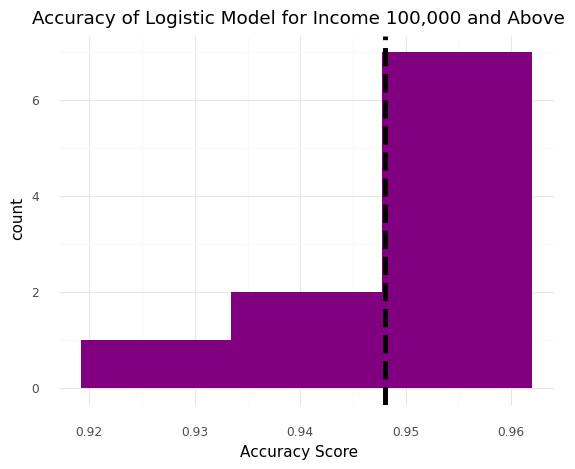

<ggplot: (178292079430)>

In [68]:
acc100 = pd.DataFrame({"acc1" : acc_100test})

(ggplot(acc100, aes(x = "acc1")) + geom_histogram(fill = "purple") + theme_minimal()
 + labs(x = "Accuracy Score")
 + ggtitle("Accuracy of Logistic Model for Income 100,000 and Above")
 + geom_vline(xintercept = np.mean(acc_100test), linetype = "dashed", size = 2)
)

#### Is your logistic regression model most accurate for people who make less than 30k, between 30-90k, or over 100k? Discuss the potential accuracy *and* ethical implications if your model *were* more accurate for different groups.

As it turns out my logistic regression model is most accurate for incomes 30,000 or less. However, looking at the mean accuracy scores for each of the income groups it appears that the difference in accuracy is not large between the income groups. If there was a large, or distinct, difference in the accuracy of my model among the income groups I would question if my results were reached because the data I used has more data from the income group with the highest accuracy score. Having more data for a specific income group is most likely the reason why my model is more accurate for that specific income group. Unfortunately, this means that most people in this income group have more health issues than other groups. Ethically, having a more accurate model for a certian income group is concerning to me because achieving a more accurate model for a specific income group means that the data collected has some internal biases that have skewed my data. In order to get a more accurate model over a broader population I need a broader sample. It is indeed helpful that my model can predict fairly accurate results for the health of a certain income group, but it is limited and therefore cannot be used for to help other people who do not fall in the specific predictive parameter. 


4. Which of the following variables is the strongest predictor of having a stroke (owning a dog, residence type, marriage, being registered to vote)? How were you able to tell?

In [41]:
coef.iloc[[3,4, 9,10]]

Names  ODDS coef  Log-odds coef  Probability coef
3     ever_married   0.828644      -0.187965          0.453147
4   Residence_type   0.980405      -0.019790          0.495053
9      reg_to_vote   0.941835      -0.059925          0.485023
10       dog_owner   1.015539       0.015419          0.503855

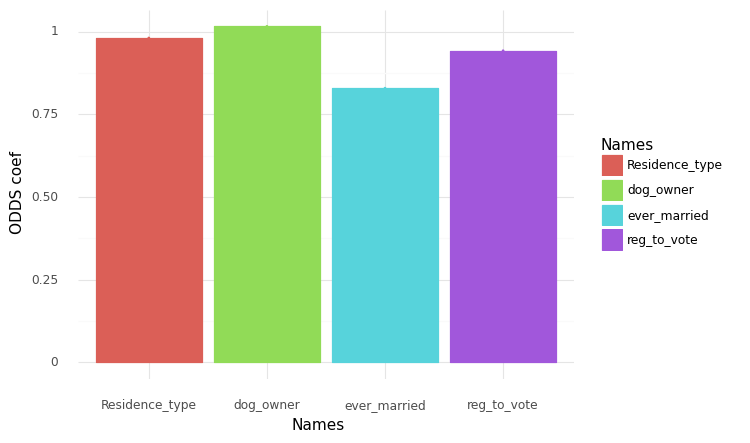

<ggplot: (178291531734)>

In [42]:
(ggplot(coef.iloc[[3,4, 9,10]], aes(x = "Names", y = "ODDS coef", fill = "Names", color = "Names")) + geom_point(size = .1)
+ theme_minimal()
+ stat_summary(geom = "bar")
)

#### Which of the following variables is the strongest predictor of having a stroke (owning a dog, residence type, marriage, being registered to vote)? How were you able to tell?

The strongest predictor between *owning a dog, residence type, marriage,* and *registered to vote* is *owning a dog* (dog_owner variable) because the odds value of the dog owner predictor variable is the highest value of the odds coefficient between the 4 predictors.

5. Create a variable `er_visits_per_year` that calculates the # of visits to the ER that a person has had per year of life. Store this variable in your data frame (no need to include this variable in the previous logistic regression model). Is the # of ER visits per year different for stroke and non-stroke patients? How can you tell?

In [43]:
er_visits_per_year = DF["er_visits"]/DF["age"]
er_visits_per_year

0        0.150000
1        1.250000
2        0.103896
3        0.216216
4        0.250000
           ...   
14995    0.173077
14996    0.285714
14997    0.400000
14998    0.077922
14999    0.090909
Length: 14222, dtype: float64

In [44]:
DFervisitperyear = DF.copy()
DFervisitperyear["er_visits_per_year"] = er_visits_per_year
DFervisitperyear

age  hypertension  heart_disease  ever_married  Residence_type  \
0      60.0           1.0            0.0           0.0             1.0   
1       4.0           0.0            0.0           0.0             0.0   
2      77.0           0.0            0.0           1.0             1.0   
3      37.0           0.0            0.0           1.0             1.0   
4      44.0           0.0            0.0           0.0             0.0   
...     ...           ...            ...           ...             ...   
14995  52.0           1.0            0.0           0.0             1.0   
14996  56.0           0.0            0.0           1.0             1.0   
14997  60.0           1.0            0.0           1.0             0.0   
14998  77.0           0.0            0.0           1.0             0.0   
14999  44.0           0.0            0.0           1.0             0.0   

       avg_glucose_level   bmi  stroke  smoking_status_smokes  \
0                  73.00  25.2       0                      1   
1                 110.15  17.1       0                      0   
2                  68.38  27.8       0                      0   
3                  95.08  30.1       0                      0   
4                 103.78  40.9       0                      1   
...                  ...   ...     ...                    ...   
14995             106.22  29.0       0                      0   
14996              63.18  26.5       0                      0   
14997             100.20  28.6       0                      0   
14998              90.00  32.0       0                      0   
14999              74.91  26.9       0                      0   

       smoking_status_formerly  reg_to_vote  dog_owner  raccoons_to_fight  \
0                            0          1.0        1.0               10.0   
1                            0          0.0        1.0               13.0   
2                            0          0.0        1.0                6.0   
3                            0          1.0        1.0               12.0   
4                            0          1.0        1.0               11.0   
...                        ...          ...        ...                ...   
14995                        0          0.0        0.0                1.0   
14996                        0          1.0        0.0               15.0   
14997                        0          0.0        1.0               17.0   
14998                        0          0.0        0.0               11.0   
14999                        0          0.0        0.0                8.0   

       fast_food_budget_month  income_in_k  er_visits  er_visits_per_year  
0                      209.19    51.553645        9.0            0.150000  
1                      176.46    45.405414        5.0            1.250000  
2                      213.00    94.865174        8.0            0.103896  
3                      161.90    84.123775        8.0            0.216216  
4                      261.29    74.794596       11.0            0.250000  
...                       ...          ...        ...                 ...  
14995                  179.77    74.826197        9.0            0.173077  
14996                  143.61    52.280949       16.0            0.285714  
14997                   64.87    92.427118       24.0            0.400000  
14998                  205.92    53.042139        6.0            0.077922  
14999                  184.14    70.317707        4.0            0.090909  

[14222 rows x 17 columns]

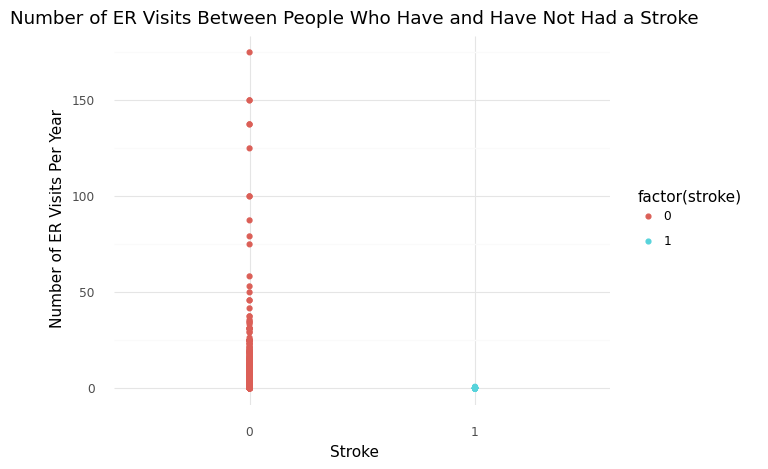

<ggplot: (178295065055)>

In [45]:
(ggplot(DF, aes(y = "er_visits_per_year", x = "factor(stroke)", color = "factor(stroke)")) + geom_point()
#  + stat_summary(geom = "bar")
 + theme_minimal()
 + ggtitle("Number of ER Visits Between People Who Have and Have Not Had a Stroke")
 + labs(x = "Stroke", y = "Number of ER Visits Per Year")
)

#### Is the # of ER visits per year different for stroke and non-stroke patients? How can you tell?

From the *Number of ER Visits Between People Who Have and Have Not Had a Stroke* plot above we can see that there is a clear difference between people who had a stoke and people who have not had a stroke with reguards to the number of ER visits per year of the persons life. For people who have not had a stoke (0) the ER visits per year of life reaches upwards of 150 ER visits. However, for people who have had a stroke (1) the number of ER visits per year of life is barely above zero visits.  